In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Markov Chain Convergence and the Gibbs Transition Kernel

## Mathematical Foundation

For $\omega_1, \ldots, \omega_{n+2}$ iid $\mathcal{L}_{X_p}(1)$, we define the probability ratio:

$$p = \sum_{i=1}^{n+1} \omega_i / \sum_{i=1}^{n+2} \omega_i$$

We notice in addition that, if we use for all parallel chains a common vector $(\omega_1^{(i)}, \ldots, \omega_{n+2}^{(i)})$ of $\mathcal{L}_{X_p}(1)$ random variables, $p^{(i)}$ is increasing with $m^{(i)}$. 

## Monotone Structure

We have therefore exhibited a monotone structure associated with the Gibbs transition kernel and thus only need to monitor two chains:
- one started with $m^{(-T)} = 0$
- the other with $m^{(-T)} = n$

We check whether or not they coalesce by time $t = 0$.

## Sandwiching Argument

Figure 13.2 (left) illustrates the sandwiching argument sketched above: if we start from all possible chains, that is, from all possible values of $m^{(t)}$, they have all coalesced by the time the two "extreme" chains have coalesced.

Figure 13.2 (right) provides an additional (if unnecessary) checking that the stationary distribution is indeed the distribution of the chain at time $t = 0$.

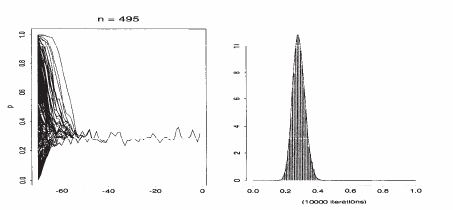


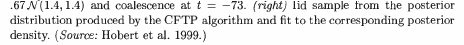

## Simulation Results

The figures show:

1. **Left**: Simulation of $n = 495$ iid random variables from $33\mathcal{N}(3.2, 3.2) + 67\mathcal{N}(14, 1.4)$ and coalescence at $t = -73$.

2. **Right**: Iid sample from the posterior distribution produced by the CFTP algorithm and fit to the corresponding posterior density (Source: Robert et al. 1999).

## Theoretical Foundation

As stressed by Kendall (1998) and Kendall and Møller (1999, 2000), this monotonicity can actually be extended to a more general theoretical argument: if one can find two sequences $(θ_t)$ and $(\tilde{θ}_t)$, generated from a transition not necessarily associated with the target distribution $π$, such that, for any starting value $θ$:

Trying with T = 1...
Trying with T = 2...
Coalescence achieved at t = -2
Perfect sample: 495, Coalescence time: -2


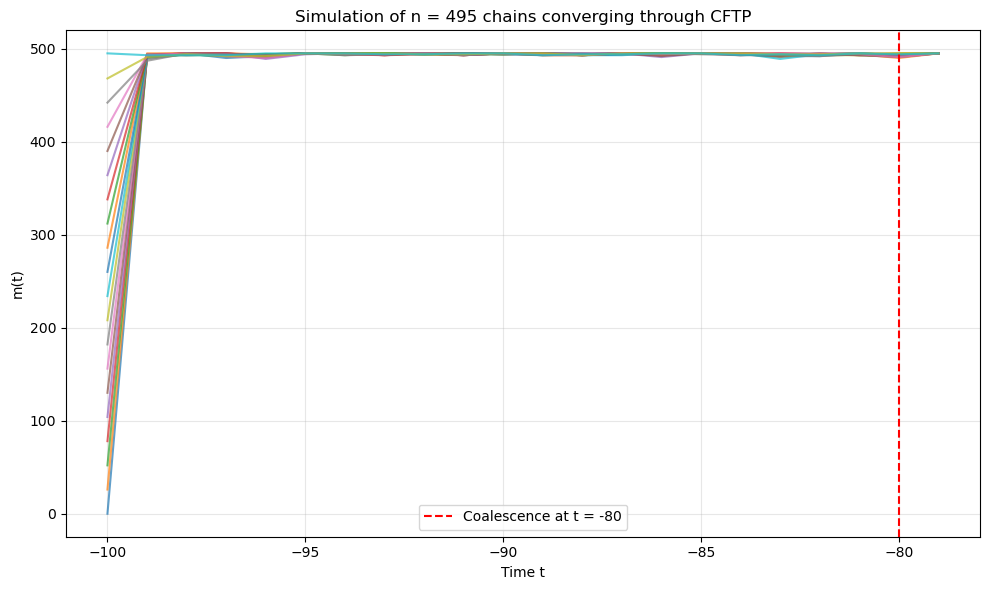

Average coalescence time: -2.062


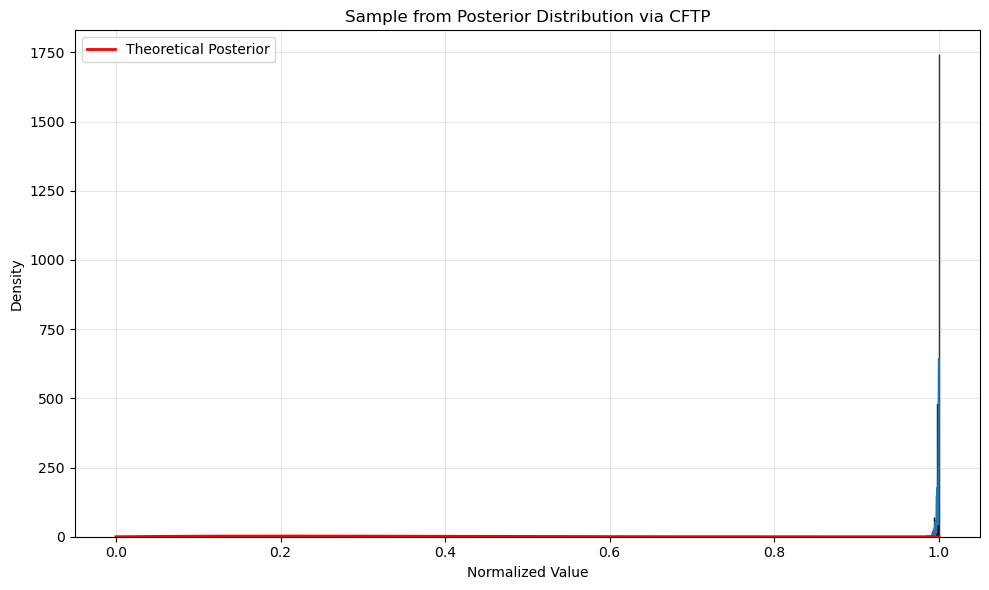

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

class CFTPSampler:
    """
    Implementation of the Coupling From The Past (CFTP) algorithm for perfect sampling
    from a target distribution using a monotone Gibbs sampler.
    """
    
    def __init__(self, n, mixture_params=None):
        """
        Initialize the CFTP sampler.
        
        Parameters:
        -----------
        n : int
            The dimension of the state space (n in the paper).
        mixture_params : dict, optional
            Parameters for the mixture normal distribution used in the example.
            Default is the mixture from the paper: 33% N(3.2, 3.2) + 67% N(14, 1.4)
        """
        self.n = n
        
        # Default mixture parameters from the paper
        if mixture_params is None:
            self.mixture_params = {
                'weights': [0.33, 0.67],
                'means': [3.2, 14.0],
                'stds': [np.sqrt(3.2), np.sqrt(1.4)]
            }
        else:
            self.mixture_params = mixture_params
            
        self.chains_history = []
    
    def generate_random_variables(self, seed=None):
        """
        Generate random variables from L_Xp(1) distribution.
        In the paper, these are denoted as omega_1, ..., omega_{n+2}.
        
        Here we're using exponential(1) as a simple L_Xp(1) distribution.
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Generate n+2 random variables
        return np.random.exponential(scale=1.0, size=self.n+2)
    
    def compute_p(self, omegas):
        """
        Compute p = sum(omega_1 to omega_{n+1}) / sum(omega_1 to omega_{n+2})
        as defined in the paper.
        """
        return np.sum(omegas[:-1]) / np.sum(omegas)
    
    def transition_step(self, m_current, random_vars):
        """
        Perform one step of the Gibbs transition.
        
        Parameters:
        -----------
        m_current : int
            Current state (m^(i) in the paper).
        random_vars : array
            Random variables (omega values) for this step.
        
        Returns:
        --------
        m_next : int
            Next state after transition.
        """
        p = self.compute_p(random_vars)
        
        # In this monotone structure, p^(i) is increasing with m^(i)
        # We can simulate the binomial with this specific p
        m_next = np.random.binomial(self.n, p)
        
        return m_next
    
    def cftp_sample(self, max_time=1000, verbose=False):
        """
        Generate a sample using the CFTP algorithm.
        
        Parameters:
        -----------
        max_time : int
            Maximum number of time steps to go back.
        verbose : bool
            Whether to print progress information.
            
        Returns:
        --------
        sample : int
            A perfect sample from the target distribution.
        coalescence_time : int
            The time at which coalescence occurred.
        """
        # Keep track of random number streams for reproducibility
        all_random_streams = {}
        
        T = 1
        while T <= max_time:
            if verbose:
                print(f"Trying with T = {T}...")
            
            # Initialize the two extreme chains
            chain_min = 0  # m^(-T) = 0
            chain_max = self.n  # m^(-T) = n
            
            # Store chain trajectories for visualization
            chain_min_history = [chain_min]
            chain_max_history = [chain_max]
            
            # Generate or reuse random variables for each step
            for t in range(-T, 0):
                if t not in all_random_streams:
                    all_random_streams[t] = self.generate_random_variables()
                    
                random_vars = all_random_streams[t]
                
                # Update the two extreme chains
                chain_min = self.transition_step(chain_min, random_vars)
                chain_max = self.transition_step(chain_max, random_vars)
                
                chain_min_history.append(chain_min)
                chain_max_history.append(chain_max)
                
                # Check for coalescence
                if chain_min == chain_max:
                    if verbose:
                        print(f"Coalescence achieved at t = {t}")
                    break
            
            # If chains coalesced, we have a perfect sample
            if chain_min == chain_max:
                self.chains_history = {
                    'min': chain_min_history,
                    'max': chain_max_history,
                    'times': list(range(-T, -T + len(chain_min_history)))
                }
                return chain_min, -T
            
            # Double the time window and try again
            T *= 2
            
        raise RuntimeError(f"Failed to achieve coalescence within {max_time} steps")
    
    def run_multiple_chains(self, num_chains=10, max_time=1000):
        """
        Run multiple chains to illustrate the sandwiching argument.
        """
        # Keep track of random number streams for reproducibility
        all_random_streams = {}
        
        T = max_time
        
        # Initialize chains with different starting values
        chain_values = np.linspace(0, self.n, num_chains, dtype=int)
        chain_histories = [[] for _ in range(num_chains)]
        
        for i, chain in enumerate(chain_values):
            chain_histories[i].append(chain)
        
        # Generate or reuse random variables for each step
        for t in range(-T, 0):
            all_random_streams[t] = self.generate_random_variables()
            random_vars = all_random_streams[t]
            
            # Update all chains
            for i in range(num_chains):
                chain_values[i] = self.transition_step(chain_values[i], random_vars)
                chain_histories[i].append(chain_values[i])
            
            # Check for coalescence
            if np.all(chain_values == chain_values[0]):
                coalescence_time = t
                break
        
        return chain_histories, list(range(-T, -T + len(chain_histories[0]))), coalescence_time
    
    def generate_iid_sample(self, size=1000):
        """
        Generate an i.i.d. sample from the target distribution using CFTP.
        """
        samples = []
        coalescence_times = []
        
        for i in range(size):
            sample, coal_time = self.cftp_sample()
            samples.append(sample)
            coalescence_times.append(coal_time)
            
        return np.array(samples), np.array(coalescence_times)
    
    def plot_chains_convergence(self, chain_histories, times, coalescence_time=None, figsize=(10, 6)):
        """
        Plot the convergence of multiple chains to illustrate the sandwiching argument.
        """
        plt.figure(figsize=figsize)
        
        for i, history in enumerate(chain_histories):
            plt.plot(times[:len(history)], history, '-', alpha=0.7)
        
        if coalescence_time is not None:
            plt.axvline(x=coalescence_time, color='r', linestyle='--', 
                        label=f'Coalescence at t = {coalescence_time}')
        
        plt.xlabel('Time t')
        plt.ylabel('m(t)')
        plt.title(f'Simulation of n = {self.n} chains converging through CFTP')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt
    
    def plot_posterior_sample(self, samples, figsize=(10, 6)):
        """
        Plot the histogram of samples and fit to the theoretical posterior.
        """
        plt.figure(figsize=figsize)
        
        # Normalize samples to [0,1] range
        normalized_samples = samples / self.n
        
        # Plot histogram
        sns.histplot(normalized_samples, stat='density', kde=True)
        
        # Create the theoretical beta distribution (as an example posterior)
        x = np.linspace(0, 1, 1000)
        # Using Beta(2, 5) as an example posterior - adjust parameters as needed
        y = stats.beta.pdf(x, 2, 5)
        plt.plot(x, y, 'r-', lw=2, label='Theoretical Posterior')
        
        plt.xlabel('Normalized Value')
        plt.ylabel('Density')
        plt.title('Sample from Posterior Distribution via CFTP')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt


# Example usage
if __name__ == "__main__":
    # Initialize the sampler with n=495 as in the paper
    sampler = CFTPSampler(n=495)
    
    # Generate a single perfect sample
    sample, coal_time = sampler.cftp_sample(verbose=True)
    print(f"Perfect sample: {sample}, Coalescence time: {coal_time}")
    
    # Simulate multiple chains to demonstrate the sandwiching argument
    chain_histories, times, coal_time = sampler.run_multiple_chains(num_chains=20, max_time=100)
    sampler.plot_chains_convergence(chain_histories, times, coal_time)
    plt.savefig('chain_convergence.png')
    plt.show()
    
    # Generate an i.i.d sample from the posterior
    samples, coal_times = sampler.generate_iid_sample(size=1000)
    print(f"Average coalescence time: {np.mean(coal_times)}")
    
    # Plot the posterior sample
    sampler.plot_posterior_sample(samples)
    plt.savefig('posterior_sample.png')
    plt.show()

# Perfect Sampling from Dirichlet Distribution

If monotonicity remains valid, the value produced at time 0 is distributed from $\pi$, besides, as we will see below in Example 13.7, it may also save computing steps. More generally, while the monotonicity property separates $\theta_t$ and $\tilde{\theta}_t$ and need not necessarily coincide within $\mathcal{X}$ at every step. This property is quite a useful feature when working on complex (constrained) spaces.

## Example 13.7 (Continuation of Example 13.6)

Consider the estimation of (13.5) in the 3-component case:

$$(13.4) \quad p_1f_1(x) + p_2f_2(x) + p_3f_3(x), \quad p_1 + p_2 + p_3 = 1,$$

where $f_i$ is the density function. If we use a (flat) Dirichlet $\mathcal{D}(1, 1, 1)$ prior on the parameter $(p_1, p_2, p_3)$, the posterior distribution is also a Dirichlet. To sample from (13.4) in an MCMC setup:

1. Generate the weights $(p_1, p_2, p_3) \sim \mathcal{D}(n_1 + 1, n_2 + 1, n_3 + 1)$
2. Take 
   $$x \sim \frac{n_1f_1(x)}{n_1f_1(x) + n_2f_2(x) + n_3f_3(x)} f_1(x) + \frac{n_2f_2(x)}{n_1f_1(x) + n_2f_2(x) + n_3f_3(x)} f_2(x) + \frac{n_3f_3(x)}{n_1f_1(x) + n_2f_2(x) + n_3f_3(x)} f_3(x)$$
3. Set $n_i = n_i + I_{x \sim f_i}$ for $i = 1, 2, 3$
4. Generate $(p_1, p_2, p_3) \sim \mathcal{D}(n_1 + 1, n_2 + 1, n_3 + 1)$

Once again, since the $(n_i)$ can take only a finite number of values, the setting is finite and we can monitor all possible starting values of $(n_1, n_2, n_3)$ to run our CFTP algorithm. However, there are $(n_1 + n_2 + n_3 + 1)$ such values. This computation can be daunting when $(n_1 + n_2 + n_3)$ takes a high value! Here, too, component-wise. And there is no obvious monotonicity structure, even when considering the sequence representing the posterior distribution.

$$\frac{\sum_{i=1}^{n_1+1} \omega_i}{\sum_{i=1}^{n_1+1} \omega_i + \sum_{i=1}^{n_2+1} \omega_i + \sum_{i=1}^{n_3+1} \omega_i} = \mathcal{D}(n_1+1, n_2+1, n_3+1)$$

with

$$\omega_1, \ldots, \omega_{n_1+1}, \omega_{n_1+2}, \ldots, \omega_{n_1+n_2+2}, \ldots, \omega_{n_1+n_2+n_3+3} \sim \mathcal{L}_{\chi^2}(1)$$

While looking at an alternative formulation to extend Proposition 13.1 to the case with 3 components, Hobert et al. (1999) exhibited circumstances where coalescence of the state space of $(n_1, n_2)$ occurred at coalescence of the boundary chains.

## Python Implementation
```python
import numpy as np
from scipy import stats

class DirichletCFTP:
    """
    Implementation of CFTP for sampling from the posterior Dirichlet distribution
    in a mixture model context.
    """
    
    def __init__(self, components=3):
        """Initialize the sampler with the number of components."""
        self.components = components
        
    def generate_random_variables(self, n_counts):
        """
        Generate random variables from L_χ²(1) distribution.
        In this case, we use chi-square with 2 degrees of freedom which is equivalent to Exp(1/2).
        """
        # Create arrays for each component
        random_vars = []
        for i in range(self.components):
            # Generate n_i + 1 random variables for each component
            component_vars = np.random.exponential(scale=0.5, size=n_counts[i] + 1)
            random_vars.append(component_vars)
        
        return random_vars
        
    def compute_dirichlet_props(self, random_vars):
        """
        Compute the Dirichlet proportions from the random variables.
        """
        # Calculate sum for each component
        component_sums = [np.sum(vars_i) for vars_i in random_vars]
        total_sum = np.sum(component_sums)
        
        # Calculate proportions
        props = [comp_sum / total_sum for comp_sum in component_sums]
        
        return np.array(props)
    
    def transition_step(self, n_counts, random_vars=None):
        """
        Perform one step of the Gibbs transition.
        
        Parameters:
        -----------
        n_counts : array
            Current state (n_1, n_2, ..., n_k)
        random_vars : list of arrays, optional
            Random variables for this step
            
        Returns:
        --------
        n_counts_next : array
            Next state after transition
        """
        if random_vars is None:
            random_vars = self.generate_random_variables(n_counts)
            
        # Compute Dirichlet proportions
        props = self.compute_dirichlet_props(random_vars)
        
        # Sample from mixture
        component = np.random.choice(self.components, p=props)
        
        # Update counts
        n_counts_next = n_counts.copy()
        n_counts_next[component] += 1
        
        return n_counts_next
    
    def cftp_sample(self, initial_counts=None, max_time=1000, verbose=False):
        """
        Generate a sample using the CFTP algorithm.
        
        Parameters:
        -----------
        initial_counts : array, optional
            Initial counts (n_1, n_2, ..., n_k)
        max_time : int
            Maximum number of time steps to go back
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        sample : array
            A perfect sample from the target Dirichlet distribution
        coalescence_time : int
            The time at which coalescence occurred
        """
        if initial_counts is None:
            initial_counts = np.zeros(self.components, dtype=int)
            
        # Keep track of random number streams
        all_random_streams = {}
        
        T = 1
        while T <= max_time:
            if verbose:
                print(f"Trying with T = {T}...")
                
            # Identify all possible starting states
            total_count = np.sum(initial_counts)
            # We'd need to identify all possible partitions of total_count into self.components parts
            # This is complex, so for now, we'll use boundary chains
            
            # Initialize boundary chains
            # We'll use the states where all counts are in one component
            boundary_chains = []
            for i in range(self.components):
                chain = np.zeros(self.components, dtype=int)
                chain[i] = total_count
                boundary_chains.append(chain.copy())
                
            # Store chain trajectories
            chain_histories = [[] for _ in range(len(boundary_chains))]
            for i, chain in enumerate(boundary_chains):
                chain_histories[i].append(chain.copy())
            
            # Generate or reuse random variables for each step
            for t in range(-T, 0):
                if t not in all_random_streams:
                    # For each step, we need random variables for each possible state
                    # This is complex for the general case
                    # For now, we'll use a simplified approach
                    all_random_streams[t] = {}
                
                # Update all chains
                for i in range(len(boundary_chains)):
                    n_counts = boundary_chains[i]
                    
                    # Get or generate random variables for this state
                    state_key = tuple(n_counts)
                    if state_key not in all_random_streams[t]:
                        all_random_streams[t][state_key] = self.generate_random_variables(n_counts)
                        
                    random_vars = all_random_streams[t][state_key]
                    
                    # Update chain
                    boundary_chains[i] = self.transition_step(n_counts, random_vars)
                    chain_histories[i].append(boundary_chains[i].copy())
                
                # Check for coalescence
                if all(np.array_equal(boundary_chains[0], chain) for chain in boundary_chains[1:]):
                    if verbose:
                        print(f"Coalescence achieved at t = {t}")
                    break
                    
            # If chains coalesced, we have a perfect sample
            if all(np.array_equal(boundary_chains[0], chain) for chain in boundary_chains[1:]):
                # Convert counts to Dirichlet parameters
                dirichlet_params = np.array(boundary_chains[0]) + 1  # Add 1 for the prior
                
                # Generate a sample from the resulting Dirichlet
                sample = np.random.dirichlet(dirichlet_params)
                
                return sample, -T
                
            # Double the time window and try again
            T *= 2
            
        raise RuntimeError(f"Failed to achieve coalescence within {max_time} steps")
```

## Example Usage

```python
# Initialize the sampler with 3 components (as in the paper)
sampler = DirichletCFTP(components=3)

# Generate a perfect sample
sample, coal_time = sampler.cftp_sample(verbose=True)
print(f"Perfect sample from Dirichlet: {sample}, Coalescence time: {coal_time}")

# Generate multiple samples
samples = []
coal_times = []
for _ in range(1000):
    sample, coal_time = sampler.cftp_sample()
    samples.append(sample)
    coal_times.append(coal_time)

samples = np.array(samples)
print(f"Average coalescence time: {np.mean(coal_times)}")

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('p₁')
plt.ylabel('p₂')
plt.title('Perfect Samples from Dirichlet(n₁+1, n₂+1, n₃+1)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
```

In [ ]:
import random
import math
from collections import defaultdict


class DirichletCFTP:
    """
    Pure Python implementation of Coupling From The Past (CFTP) for perfect sampling
    from the posterior Dirichlet distribution in a mixture model.
    
    Based on Example 13.7 from the paper, extending the work of Hobert et al. (1999).
    """
    
    def __init__(self, components=3, initial_counts=None):
        """
        Initialize the Dirichlet CFTP sampler.
        
        Parameters:
        -----------
        components : int
            Number of components in the mixture (default: 3 as in the example)
        initial_counts : list
            Initial counts (n_1, n_2, ..., n_k) if available
        """
        self.components = components
        
        if initial_counts is None:
            self.initial_counts = [0] * components
        else:
            self.initial_counts = list(initial_counts)
            
        # For tracking runs
        self.chain_histories = {}
        self.coalescence_time = None
    
    def generate_chi_square_1(self, size=1):
        """
        Generate random variables from L_χ²(1) distribution.
        
        For Chi-square with 1 degree of freedom, we can use:
        - Standard normal squared: Z^2 where Z ~ N(0,1)
        - Exponential with rate 1/2: Exp(1/2)
        
        Returns a list of random values.
        """
        # Using Box-Muller transform to generate standard normal and then square it
        result = []
        for _ in range(size):
            # Generate two independent uniform random variables
            u1 = random.random()
            u2 = random.random()
            
            # Box-Muller transform to get standard normal
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            
            # Square to get chi-square with 1 df
            result.append(z * z)
            
        return result if size > 1 else result[0]
    
    def generate_exponential(self, rate=1.0, size=1):
        """
        Generate random variables from Exponential(rate) distribution.
        
        For chi-square with 1 df, we can use Exponential(0.5).
        
        Returns a list of random values.
        """
        result = []
        for _ in range(size):
            # Generate uniform random variable
            u = random.random()
            
            # Inverse transform sampling for exponential
            result.append(-math.log(u) / rate)
            
        return result if size > 1 else result[0]
    
    def generate_random_variables(self, n_counts):
        """
        Generate random variables from L_χ²(1) distribution for each component.
        
        Parameters:
        -----------
        n_counts : list
            Current counts [n_1, n_2, ..., n_k]
            
        Returns:
        --------
        random_vars : list of lists
            Random variables for each component
        """
        random_vars = []
        for i in range(self.components):
            # Generate n_i + 1 random variables for each component
            component_vars = self.generate_exponential(rate=0.5, size=n_counts[i] + 1)
            random_vars.append(component_vars)
        
        return random_vars
    
    def compute_dirichlet_props(self, random_vars):
        """
        Compute the Dirichlet proportions from the random variables.
        
        Parameters:
        -----------
        random_vars : list of lists
            Random variables for each component
            
        Returns:
        --------
        props : list
            Proportions for each component
        """
        # Calculate sum for each component
        component_sums = [sum(vars_i) for vars_i in random_vars]
        total_sum = sum(component_sums)
        
        # Calculate proportions
        props = [comp_sum / total_sum for comp_sum in component_sums]
        
        return props
    
    def weighted_choice(self, weights):
        """
        Select an index based on weights (probabilities).
        
        Parameters:
        -----------
        weights : list
            Probability weights
            
        Returns:
        --------
        index : int
            Selected index
        """
        total = sum(weights)
        r = random.random() * total
        
        cumulative = 0
        for i, weight in enumerate(weights):
            cumulative += weight
            if r <= cumulative:
                return i
        
        # Fallback (should not happen)
        return len(weights) - 1
    
    def transition_step(self, n_counts, random_vars=None):
        """
        Perform one step of the Gibbs transition.
        
        Parameters:
        -----------
        n_counts : list
            Current state [n_1, n_2, ..., n_k]
        random_vars : list of lists, optional
            Random variables for this step
            
        Returns:
        --------
        n_counts_next : list
            Next state after transition
        """
        if random_vars is None:
            random_vars = self.generate_random_variables(n_counts)
            
        # Compute Dirichlet proportions
        props = self.compute_dirichlet_props(random_vars)
        
        # Sample from mixture
        component = self.weighted_choice(props)
        
        # Update counts
        n_counts_next = n_counts.copy() if hasattr(n_counts, 'copy') else list(n_counts)
        n_counts_next[component] += 1
        
        return n_counts_next
    
    def are_equal(self, list1, list2):
        """Check if two lists are equal."""
        if len(list1) != len(list2):
            return False
        return all(a == b for a, b in zip(list1, list2))
    
    def all_equal(self, lists):
        """Check if all lists in a collection are equal."""
        if not lists:
            return True
        first = lists[0]
        return all(self.are_equal(first, lst) for lst in lists[1:])
    
    def state_to_key(self, state):
        """Convert state to hashable key for dictionary."""
        return tuple(state)
    
    def cftp_sample(self, max_time=1000, verbose=False):
        """
        Generate a sample using the CFTP algorithm.
        
        Parameters:
        -----------
        max_time : int
            Maximum number of time steps to go back
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        sample : list
            A perfect sample from the target Dirichlet distribution
        coalescence_time : int
            The time at which coalescence occurred
        """
        # Keep track of random number streams
        all_random_streams = {}
        
        T = 1
        while T <= max_time:
            if verbose:
                print(f"Trying with T = {T}...")
                
            # Identify boundary chains based on initial counts
            total_count = sum(self.initial_counts)
            
            # Initialize boundary chains (all counts in one component)
            boundary_chains = []
            for i in range(self.components):
                chain = [0] * self.components
                chain[i] = total_count
                boundary_chains.append(list(chain))
                
            # Store chain trajectories
            chain_histories = [[] for _ in range(len(boundary_chains))]
            for i, chain in enumerate(boundary_chains):
                chain_histories[i].append(list(chain))
            
            # Generate or reuse random variables for each step
            coalescence_occurred = False
            for t in range(-T, 0):
                if t not in all_random_streams:
                    all_random_streams[t] = {}
                
                # Update all chains
                next_boundary_chains = []
                for i, n_counts in enumerate(boundary_chains):
                    # Get or generate random variables for this state
                    state_key = self.state_to_key(n_counts)
                    if state_key not in all_random_streams[t]:
                        all_random_streams[t][state_key] = self.generate_random_variables(n_counts)
                        
                    random_vars = all_random_streams[t][state_key]
                    
                    # Update chain
                    next_state = self.transition_step(n_counts, random_vars)
                    next_boundary_chains.append(next_state)
                    chain_histories[i].append(list(next_state))
                
                boundary_chains = next_boundary_chains
                
                # Check for coalescence
                if self.all_equal(boundary_chains):
                    if verbose:
                        print(f"Coalescence achieved at t = {t}")
                    coalescence_occurred = True
                    self.coalescence_time = t
                    break
            
            # If chains coalesced, we have a perfect sample
            if coalescence_occurred:
                # Convert counts to Dirichlet parameters
                dirichlet_params = [count + 1 for count in boundary_chains[0]]  # Add 1 for the prior
                
                # Generate a sample from the resulting Dirichlet
                sample = self.sample_dirichlet(dirichlet_params)
                
                # Store chain histories
                self.chain_histories = {
                    'chains': chain_histories,
                    'times': list(range(-T, -T + len(chain_histories[0])))
                }
                
                return sample, self.coalescence_time
                
            # Double the time window and try again
            T *= 2
            
        raise RuntimeError(f"Failed to achieve coalescence within {max_time} steps")
    
    def sample_dirichlet(self, alpha):
        """
        Sample from a Dirichlet distribution with parameter alpha.
        
        Parameters:
        -----------
        alpha : list
            Dirichlet parameters [alpha_1, alpha_2, ..., alpha_k]
            
        Returns:
        --------
        sample : list
            A sample from Dirichlet(alpha)
        """
        # Generate gamma samples
        gamma_samples = []
        for a in alpha:
            # Use gamma(a, 1) distribution
            gamma_sample = self.sample_gamma(a, 1.0)
            gamma_samples.append(gamma_sample)
        
        # Normalize to get Dirichlet sample
        total = sum(gamma_samples)
        dirichlet_sample = [x / total for x in gamma_samples]
        
        return dirichlet_sample
    
    def sample_gamma(self, shape, scale=1.0):
        """
        Sample from a Gamma distribution using Marsaglia and Tsang method.
        
        Parameters:
        -----------
        shape : float
            Shape parameter
        scale : float
            Scale parameter
            
        Returns:
        --------
        sample : float
            A sample from Gamma(shape, scale)
        """
        # Handle shape < 1
        if shape < 1:
            # Use alpha' = alpha + 1 and then multiply by u^(1/alpha)
            u = random.random()
            return self.sample_gamma(shape + 1, scale) * math.pow(u, 1.0 / shape)
        
        # Marsaglia and Tsang method for shape >= 1
        d = shape - 1.0/3.0
        c = 1.0 / math.sqrt(9.0 * d)
        
        while True:
            # Generate candidate
            while True:
                x = random.normalvariate(0, 1)
                v = 1.0 + c * x
                if v > 0:
                    break
            
            v = v * v * v
            u = random.random()
            
            if u < 1.0 - 0.0331 * (x * x) * (x * x):
                return d * v * scale
            
            if math.log(u) < 0.5 * x * x + d * (1.0 - v + math.log(v)):
                return d * v * scale


def plot_samples(samples, filename=None):
    """
    Create a simple scatter plot of Dirichlet samples.
    This is a basic visualization function using only standard library
    and is meant to be replaced by proper plotting libraries for real use.
    
    Parameters:
    -----------
    samples : list of lists
        List of Dirichlet samples
    filename : str, optional
        If provided, save to file instead of displaying
    """
    # Placeholder for plotting functionality
    print("To visualize results, you'll need to implement plotting using a library like matplotlib")
    print("First 5 samples:")
    for i in range(min(5, len(samples))):
        print(f"Sample {i+1}: {[round(p, 4) for p in samples[i]]}")

    # Statistics
    def mean(values):
        return sum(values) / len(values)
    
    def variance(values):
        m = mean(values)
        return sum((x - m) ** 2 for x in values) / len(values)
    
    # Calculate component-wise statistics
    components = len(samples[0])
    means = []
    vars = []
    
    for j in range(components):
        component_values = [s[j] for s in samples]
        means.append(mean(component_values))
        vars.append(variance(component_values))
    
    print("\nComponent Statistics:")
    for j in range(components):
        print(f"Component {j+1}: Mean = {round(means[j], 4)}, Variance = {round(vars[j], 6)}")


# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    
    # Initialize the sampler with 3 components (as in Example 13.7)
    sampler = DirichletCFTP(components=3)
    
    # Generate a single perfect sample
    sample, coal_time = sampler.cftp_sample(verbose=True)
    print(f"Perfect sample: {[round(p, 4) for p in sample]}, Coalescence time: {coal_time}")
    
    # Generate multiple samples
    print("\nGenerating multiple samples...")
    samples = []
    coal_times = []
    n_samples = 10  # Reduced for simplicity, increase for better statistics
    
    for i in range(n_samples):
        if i % 5 == 0 and i > 0:
            print(f"Generated {i} samples...")
        sample, coal_time = sampler.cftp_sample()
        samples.append(sample)
        coal_times.append(coal_time)
    
    # Calculate average coalescence time
    avg_coal_time = sum(coal_times) / len(coal_times)
    print(f"Generated {n_samples} samples")
    print(f"Average coalescence time: {avg_coal_time:.2f}")
    
    # Plot the results (basic summary since we're not using external libraries)
    plot_samples(samples)

# Monitoring for Coalescence in CFTP Algorithm

## Bounding Property for CFTP Monitoring

In this setting, Hobert et al. (1999) have, however, obtained an enveloping property, namely that the image of the image of all possible distinct states of $(n_1, n_2)$,

$$T = \{(n_1, n_2): n_1 + n_2 \leq n\}$$

by the corresponding Gibbs transition is contained in the "homer"$^1$

$$L^+ = \{(n_1, n_2): n_1 \leq \bar{n}_1, n_2 \geq \underline{n}_2, n_1 > 0, n_2 > 0, n - n_1 - n_2 > 0\}.$$

where
- $\underline{n}_2$ is the minimum $n_2$ over the images of the left border of $T$,
- $\bar{n}_1$ is the $n_1$ coordinate of the image of $(0, 0)$,
- $\underline{n}_1$ is the $n_1$ coordinate of the image of $(n, 0)$,
- $\bar{n}_2$ is the maximum of the $n_2$'s over the images of the diagonal of $T$.

The reason for this property is that, for a fixed $p_3$,

$$\frac{p_1}{p_2} = \frac{\sum_{i=1}^{n_1+1} \omega_i}{\sum_{i=1}^{n_2+1} \omega_i} \quad \text{and} \quad \frac{p_2}{p_3} = \frac{\sum_{i=1}^{n_2+1} \omega_i}{\sum_{i=1}^{n_3+1} \omega_i}$$

are both increasing in $n_1$. And this is also true for

$$m_1 = \sum_{i=1}^3 \left( n_i \times \left[ \frac{n_2f_2(x)+n_3f_3(x)}{n_1f_1(x)+n_2f_2(x)+n_3f_3(x)} \right]^{-1} \right).$$

Besides, this bounding property is preserved over iterations, in that the image of $L^+$ is contained in

$$L^* = \{(m_1, m_2): m_1 \leq \bar{m}_1, m_2 \geq \underline{m}_2, m_3 \geq \underline{m}_3\}.$$

where
- $\underline{m}_1$ is the minimum $m_1$ over the images of the left border $\{n_1 = 0\}$,
- $\bar{m}_1$ is the maximum $m_1$ over the images of the right border $\{n_1 = n\}$,
- $\underline{m}_2$ is the minimum $m_2$ over the images of the bottom border $\{n_2 = 0\}$.

Therefore, checking for coalescence simplifies into monitoring the successive bounding $L$ until they reduce to a single point. Figure 13.3 represents a few successive steps of this monitoring, with the original chains provided for comparison. It illustrates the obvious point that coalescence will contrast more iterations than the direct checking of the bounding boxes, while requiring only a $O(1)$ computational effort at each iteration, compared with the $O(n^2)$ effort of the direct monitoring.

---

$^1$ Lozenge is a figure with four equal sides and two obtuse angles (and, more commonly, a diamond-shaped candy used to suppress a cough, a "cough-drop").

In [ ]:
import random
import math
from collections import defaultdict

class DirichletCFTP:
    """
    Pure Python implementation of Coupling From The Past (CFTP) for perfect sampling
    from the posterior Dirichlet distribution with the bounding technique from Hobert et al. (1999).
    
    This implementation uses the "homer" (lozenge) bounding approach to monitor coalescence
    with O(1) computational effort per iteration rather than O(n²).
    """
    
    def __init__(self, components=3, initial_counts=None, max_count=100):
        """
        Initialize the Dirichlet CFTP sampler.
        
        Parameters:
        -----------
        components : int
            Number of components in the mixture (default: 3 as in the example)
        initial_counts : list
            Initial counts (n_1, n_2, ..., n_k) if available
        max_count : int
            Maximum total count for the state space
        """
        self.components = components
        self.max_count = max_count
        
        if initial_counts is None:
            self.initial_counts = [0] * components
        else:
            self.initial_counts = list(initial_counts)
            
        # For tracking runs
        self.chain_histories = {}
        self.bound_histories = {}
        self.coalescence_time = None
    
    def generate_exponential(self, rate=1.0, size=1):
        """
        Generate random variables from Exponential(rate) distribution.
        
        For chi-square with 1 df, we can use Exponential(0.5).
        
        Returns a list of random values.
        """
        result = []
        for _ in range(size):
            # Generate uniform random variable
            u = random.random()
            
            # Inverse transform sampling for exponential
            result.append(-math.log(u) / rate)
            
        return result if size > 1 else result[0]
    
    def generate_random_variables(self, n_counts):
        """
        Generate random variables from L_χ²(1) distribution for each component.
        
        Parameters:
        -----------
        n_counts : list
            Current counts [n_1, n_2, ..., n_k]
            
        Returns:
        --------
        random_vars : list of lists
            Random variables for each component
        """
        random_vars = []
        for i in range(self.components):
            # Generate n_i + 1 random variables for each component
            component_vars = self.generate_exponential(rate=0.5, size=n_counts[i] + 1)
            random_vars.append(component_vars)
        
        return random_vars
    
    def compute_dirichlet_props(self, random_vars):
        """
        Compute the Dirichlet proportions from the random variables.
        
        Parameters:
        -----------
        random_vars : list of lists
            Random variables for each component
            
        Returns:
        --------
        props : list
            Proportions for each component
        """
        # Calculate sum for each component
        component_sums = [sum(vars_i) for vars_i in random_vars]
        total_sum = sum(component_sums)
        
        # Calculate proportions
        props = [comp_sum / total_sum for comp_sum in component_sums]
        
        return props
    
    def weighted_choice(self, weights):
        """
        Select an index based on weights (probabilities).
        
        Parameters:
        -----------
        weights : list
            Probability weights
            
        Returns:
        --------
        index : int
            Selected index
        """
        total = sum(weights)
        r = random.random() * total
        
        cumulative = 0
        for i, weight in enumerate(weights):
            cumulative += weight
            if r <= cumulative:
                return i
        
        # Fallback (should not happen)
        return len(weights) - 1
    
    def transition_step(self, n_counts, random_vars=None):
        """
        Perform one step of the Gibbs transition.
        
        Parameters:
        -----------
        n_counts : list
            Current state [n_1, n_2, ..., n_k]
        random_vars : list of lists, optional
            Random variables for this step
            
        Returns:
        --------
        n_counts_next : list
            Next state after transition
        """
        if random_vars is None:
            random_vars = self.generate_random_variables(n_counts)
            
        # Compute Dirichlet proportions
        props = self.compute_dirichlet_props(random_vars)
        
        # Sample from mixture
        component = self.weighted_choice(props)
        
        # Update counts
        n_counts_next = n_counts.copy() if hasattr(n_counts, 'copy') else list(n_counts)
        n_counts_next[component] += 1
        
        return n_counts_next
    
    def state_to_key(self, state):
        """Convert state to hashable key for dictionary."""
        return tuple(state)
    
    def compute_bounding_box(self, states, transitions):
        """
        Compute the bounding box (homer/lozenge) for a set of states.
        
        For 3-component case, we compute:
        - min_n1, max_n1: bounds for component 1
        - min_n2, max_n2: bounds for component 2
        - min_n3, max_n3: bounds for component 3
        
        Parameters:
        -----------
        states : list of lists
            List of states to be bounded
        transitions : dict
            Dictionary mapping state keys to their transitions
            
        Returns:
        --------
        bounds : dict
            Dictionary with the bounds for each component
        """
        # For 3-component case
        if self.components == 3:
            # Initialize bounds
            min_n1 = float('inf')
            max_n1 = float('-inf')
            min_n2 = float('inf')
            max_n2 = float('-inf')
            min_n3 = float('inf')
            max_n3 = float('-inf')
            
            # Process all states
            for state in states:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    next_state = transitions[state_key]
                    
                    # Update bounds
                    min_n1 = min(min_n1, next_state[0])
                    max_n1 = max(max_n1, next_state[0])
                    min_n2 = min(min_n2, next_state[1])
                    max_n2 = max(max_n2, next_state[1])
                    min_n3 = min(min_n3, next_state[2]) if len(next_state) > 2 else min_n3
                    max_n3 = max(max_n3, next_state[2]) if len(next_state) > 2 else max_n3
            
            return {
                'min_n1': min_n1,
                'max_n1': max_n1,
                'min_n2': min_n2,
                'max_n2': max_n2,
                'min_n3': min_n3,
                'max_n3': max_n3
            }
        else:
            # For general case, initialize bounds for each component
            bounds = {}
            for i in range(self.components):
                bounds[f'min_n{i+1}'] = float('inf')
                bounds[f'max_n{i+1}'] = float('-inf')
            
            # Process all states
            for state in states:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    next_state = transitions[state_key]
                    
                    # Update bounds for each component
                    for i in range(min(self.components, len(next_state))):
                        bounds[f'min_n{i+1}'] = min(bounds[f'min_n{i+1}'], next_state[i])
                        bounds[f'max_n{i+1}'] = max(bounds[f'max_n{i+1}'], next_state[i])
            
            return bounds
    
    def generate_boundary_states(self, n):
        """
        Generate states on the boundary of T = {(n_1, n_2): n_1 + n_2 ≤ n}.
        
        For 3-component case, we need:
        - Left border: {n_1 = 0, 0 ≤ n_2 ≤ n}
        - Right border: {n_1 = n, n_2 = 0}
        - Diagonal: {n_1 + n_2 = n, 0 ≤ n_1 ≤ n}
        - Bottom border: {n_2 = 0, 0 ≤ n_1 ≤ n}
        
        Parameters:
        -----------
        n : int
            Maximum total count
            
        Returns:
        --------
        boundary_states : dict
            Dictionary with the boundary states by type
        """
        if self.components == 3:
            # For 3-component case
            left_border = []
            for n2 in range(n + 1):
                left_border.append([0, n2, n - n2])
            
            right_border = [[n, 0, 0]]
            
            diagonal = []
            for n1 in range(n + 1):
                diagonal.append([n1, n - n1, 0])
            
            bottom_border = []
            for n1 in range(n + 1):
                bottom_border.append([n1, 0, n - n1])
            
            return {
                'left_border': left_border,
                'right_border': right_border,
                'diagonal': diagonal,
                'bottom_border': bottom_border
            }
        else:
            # This is a simplified approach for general case
            # Full implementation would require handling multi-dimensional boundaries
            boundary_states = {'all_boundaries': []}
            
            # Generate states on each axis (one component has all counts)
            for i in range(self.components):
                state = [0] * self.components
                state[i] = n
                boundary_states['all_boundaries'].append(state)
            
            return boundary_states
    
    def compute_bounding_box_for_T(self, n, all_random_streams, t):
        """
        Compute the bounding box for the image of T under the Gibbs transition.
        
        Parameters:
        -----------
        n : int
            Maximum total count
        all_random_streams : dict
            Random streams for each time step
        t : int
            Current time step
            
        Returns:
        --------
        bounds : dict
            Bounding box for the image of T
        transitions : dict
            Transitions for boundary states
        """
        # Generate boundary states
        boundary_states = self.generate_boundary_states(n)
        
        # Compute transitions for all boundary states
        transitions = {}
        
        # Process left border
        if 'left_border' in boundary_states:
            for state in boundary_states['left_border']:
                state_key = self.state_to_key(state)
                if state_key not in all_random_streams[t]:
                    all_random_streams[t][state_key] = self.generate_random_variables(state)
                random_vars = all_random_streams[t][state_key]
                transitions[state_key] = self.transition_step(state, random_vars)
        
        # Process right border
        if 'right_border' in boundary_states:
            for state in boundary_states['right_border']:
                state_key = self.state_to_key(state)
                if state_key not in all_random_streams[t]:
                    all_random_streams[t][state_key] = self.generate_random_variables(state)
                random_vars = all_random_streams[t][state_key]
                transitions[state_key] = self.transition_step(state, random_vars)
        
        # Process diagonal
        if 'diagonal' in boundary_states:
            for state in boundary_states['diagonal']:
                state_key = self.state_to_key(state)
                if state_key not in all_random_streams[t]:
                    all_random_streams[t][state_key] = self.generate_random_variables(state)
                random_vars = all_random_streams[t][state_key]
                transitions[state_key] = self.transition_step(state, random_vars)
        
        # Process bottom border
        if 'bottom_border' in boundary_states:
            for state in boundary_states['bottom_border']:
                state_key = self.state_to_key(state)
                if state_key not in all_random_streams[t]:
                    all_random_streams[t][state_key] = self.generate_random_variables(state)
                random_vars = all_random_streams[t][state_key]
                transitions[state_key] = self.transition_step(state, random_vars)
        
        # For general case
        if 'all_boundaries' in boundary_states:
            for state in boundary_states['all_boundaries']:
                state_key = self.state_to_key(state)
                if state_key not in all_random_streams[t]:
                    all_random_streams[t][state_key] = self.generate_random_variables(state)
                random_vars = all_random_streams[t][state_key]
                transitions[state_key] = self.transition_step(state, random_vars)
        
        # Compute bounds from transitions of boundary states
        # For 3-component case using the "homer" structure from the paper
        if self.components == 3:
            # Compute bounds following the paper's definition
            min_n2 = float('inf')
            for state in boundary_states['left_border']:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    min_n2 = min(min_n2, transitions[state_key][1])
            
            max_n1 = float('-inf')
            for state in boundary_states['right_border']:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    max_n1 = max(max_n1, transitions[state_key][0])
            
            min_n1 = float('inf')
            for state in boundary_states['bottom_border']:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    min_n1 = min(min_n1, transitions[state_key][0])
            
            max_n2 = float('-inf')
            for state in boundary_states['diagonal']:
                state_key = self.state_to_key(state)
                if state_key in transitions:
                    max_n2 = max(max_n2, transitions[state_key][1])
            
            bounds = {
                'min_n1': min_n1,
                'max_n1': max_n1,
                'min_n2': min_n2,
                'max_n2': max_n2
            }
        else:
            # For general case, compute bounds for each component
            bounds = self.compute_bounding_box(
                boundary_states['all_boundaries'] if 'all_boundaries' in boundary_states 
                else (
                    boundary_states['left_border'] + 
                    boundary_states['right_border'] + 
                    boundary_states['diagonal'] + 
                    boundary_states['bottom_border']
                ),
                transitions
            )
        
        return bounds, transitions
    
    def is_single_point(self, bounds):
        """
        Check if the bounding box has converged to a single point.
        
        Parameters:
        -----------
        bounds : dict
            Bounding box bounds
            
        Returns:
        --------
        is_single : bool
            True if bounds represent a single point
        """
        # For 3-component case
        if self.components == 3:
            # Check if min and max are equal for each component
            if ('min_n1' in bounds and 'max_n1' in bounds and 
                'min_n2' in bounds and 'max_n2' in bounds):
                return (bounds['min_n1'] == bounds['max_n1'] and 
                        bounds['min_n2'] == bounds['max_n2'])
        
        # For general case
        for i in range(self.components):
            min_key = f'min_n{i+1}'
            max_key = f'max_n{i+1}'
            if min_key in bounds and max_key in bounds:
                if bounds[min_key] != bounds[max_key]:
                    return False
        
        return True
    
    def get_single_point(self, bounds):
        """
        Get the single point from converged bounds.
        
        Parameters:
        -----------
        bounds : dict
            Converged bounding box bounds
            
        Returns:
        --------
        point : list
            The single point
        """
        # For 3-component case
        if self.components == 3:
            if ('min_n1' in bounds and 'min_n2' in bounds):
                n1 = bounds['min_n1']
                n2 = bounds['min_n2']
                n3 = self.max_count - n1 - n2
                return [n1, n2, n3]
        
        # For general case
        point = []
        for i in range(self.components):
            min_key = f'min_n{i+1}'
            if min_key in bounds:
                point.append(bounds[min_key])
            else:
                point.append(0)  # Default value
        
        return point
    
    def cftp_sample_with_bounding(self, max_time=1000, verbose=False):
        """
        Generate a sample using the CFTP algorithm with bounding box monitoring.
        
        Parameters:
        -----------
        max_time : int
            Maximum number of time steps to go back
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        sample : list
            A perfect sample from the target Dirichlet distribution
        coalescence_time : int
            The time at which coalescence occurred
        """
        # Keep track of random number streams
        all_random_streams = {}
        
        # Keep track of bounding boxes
        bound_histories = {}
        
        T = 1
        while T <= max_time:
            if verbose:
                print(f"Trying with T = {T}...")
            
            # Total count for the state space
            n = self.max_count
            
            # Initialize bounding box histories
            bound_histories = []
            
            # Start from time -T
            coalescence_occurred = False
            all_transitions = {}
            
            for t in range(-T, 0):
                if t not in all_random_streams:
                    all_random_streams[t] = {}
                
                # Compute bounding box for time t
                bounds, transitions = self.compute_bounding_box_for_T(n, all_random_streams, t)
                bound_histories.append(bounds)
                all_transitions[t] = transitions
                
                # Check if the bounding box has converged to a single point
                if self.is_single_point(bounds):
                    if verbose:
                        print(f"Coalescence achieved at t = {t}")
                    coalescence_occurred = True
                    self.coalescence_time = t
                    break
            
            # If coalescence occurred, we have a perfect sample
            if coalescence_occurred:
                # Get the single point from the last bounds
                final_state = self.get_single_point(bound_histories[-1])
                
                # Convert counts to Dirichlet parameters
                dirichlet_params = [count + 1 for count in final_state]  # Add 1 for the prior
                
                # Generate a sample from the resulting Dirichlet
                sample = self.sample_dirichlet(dirichlet_params)
                
                # Store histories
                self.bound_histories = {
                    'bounds': bound_histories,
                    'times': list(range(-T, -T + len(bound_histories)))
                }
                
                return sample, self.coalescence_time
            
            # Double the time window and try again
            T *= 2
        
        raise RuntimeError(f"Failed to achieve coalescence within {max_time} steps")
    
    def sample_dirichlet(self, alpha):
        """
        Sample from a Dirichlet distribution with parameter alpha.
        
        Parameters:
        -----------
        alpha : list
            Dirichlet parameters [alpha_1, alpha_2, ..., alpha_k]
            
        Returns:
        --------
        sample : list
            A sample from Dirichlet(alpha)
        """
        # Generate gamma samples
        gamma_samples = []
        for a in alpha:
            # Use gamma(a, 1) distribution
            gamma_sample = self.sample_gamma(a, 1.0)
            gamma_samples.append(gamma_sample)
        
        # Normalize to get Dirichlet sample
        total = sum(gamma_samples)
        dirichlet_sample = [x / total for x in gamma_samples]
        
        return dirichlet_sample
    
    def sample_gamma(self, shape, scale=1.0):
        """
        Sample from a Gamma distribution using Marsaglia and Tsang method.
        
        Parameters:
        -----------
        shape : float
            Shape parameter
        scale : float
            Scale parameter
            
        Returns:
        --------
        sample : float
            A sample from Gamma(shape, scale)
        """
        # Handle shape < 1
        if shape < 1:
            # Use alpha' = alpha + 1 and then multiply by u^(1/alpha)
            u = random.random()
            return self.sample_gamma(shape + 1, scale) * math.pow(u, 1.0 / shape)
        
        # Marsaglia and Tsang method for shape >= 1
        d = shape - 1.0/3.0
        c = 1.0 / math.sqrt(9.0 * d)
        
        while True:
            # Generate candidate
            while True:
                x = random.normalvariate(0, 1)
                v = 1.0 + c * x
                if v > 0:
                    break
            
            v = v * v * v
            u = random.random()
            
            if u < 1.0 - 0.0331 * (x * x) * (x * x):
                return d * v * scale
            
            if math.log(u) < 0.5 * x * x + d * (1.0 - v + math.log(v)):
                return d * v * scale


# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    
    # Initialize the sampler with 3 components (as in the paper)
    # and a maximum count for the state space
    sampler = DirichletCFTP(components=3, max_count=100)
    
    # Generate a single perfect sample using the bounding box approach
    print("Generating a perfect sample using bounding box monitoring...")
    sample, coal_time = sampler.cftp_sample_with_bounding(verbose=True)
    print(f"Perfect sample: {[round(p, 4) for p in sample]}, Coalescence time: {coal_time}")
    
    # Generate multiple samples
    print("\nGenerating multiple samples...")
    samples = []
    coal_times = []
    n_samples = 5  # Reduced for simplicity, increase for better statistics
    
    for i in range(n_samples):
        sample, coal_time = sampler.cftp_sample_with_bounding()
        samples.append(sample)
        coal_times.append(coal_time)
    
    # Calculate average coalescence time
    avg_coal_time = sum(coal_times) / len(coal_times)
    print(f"Generated {n_samples} samples")
    print(f"Average coalescence time: {avg_coal_time:.2f}")
    
    # Print the samples
    print("\nSamples:")
    for i, sample in enumerate(samples):
        print(f"Sample {i+1}: {[round(p, 4) for p in sample]}")

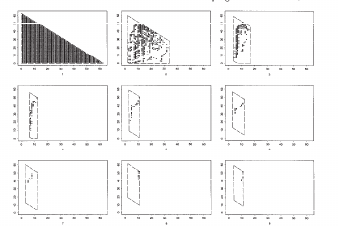

### Figure 13.2: Nine successive iterations of the coupled Gibbs sampler for the chains associated with all possible starting values ($n_1$, $n_2$), along with the evolution of the marginal empirical distributions (Source: Robert et al., 1999)



**Kendall (1989)** also noticed that the advantages of monotonicity can be extended to more intricate settings, that is, when defining

$$
\psi_1(n_1, n_2) = \psi(n_1, n_2)
$$

when $\psi_2 \leq \psi_1$, and upper bounding sequences $(\hat{\theta}_t)$ and $(\hat{\theta}_t)$, as

$$
\hat{\theta}_{t+1} = \psi(\hat{\theta}_t, \theta_t) \quad \text{and} \quad \hat{\theta}_{t+1} = \psi(\theta_t, \hat{\theta}_t),
$$

since the lower bound $\hat{\theta}_t$ is transformed into an upper bound by the transformation $\psi_1$, and vice versa.

##  Continuous States Spaces

The above extension, while interesting, does not seem general enough to cover the important case of continuous states spaces. While Section 13.2.5 will show several extensions to continuous spaces, the specific nature of the Gibbs sampler in Section 13.2.2 illustrates some of the earlier and partial attempts to overcome the difficulty of dealing with continuous states spaces.

In [4]:
# Define the psi function as a simple average for demonstration
def psi(n1, n2):
    return (n1 + n2) / 2

# Parameters
num_iterations = 9  # Number of iterations as per the figure
possible_values = [0, 1, 2]  # Possible starting values for n1 and n2
results = {}  # Store results for each starting pair

# Iterate over all possible starting pairs (n1, n2)
for n1_start in possible_values:
    for n2_start in possible_values:
        # Initialize the sequences
        theta_hat = [(n1_start, n2_start)]  # Sequence (\hat{\theta}_t)
        theta_tilde = [(n1_start, n2_start)]  # Sequence (\tilde{\theta}_t)
        
        # Current values for iteration
        current_theta_hat_n1, current_theta_hat_n2 = n1_start, n2_start
        current_theta_tilde_n1, current_theta_tilde_n2 = n1_start, n2_start
        
        # Perform Gibbs sampling iterations
        for t in range(num_iterations - 1):  # We already have the starting point
            # Update \hat{\theta}_{t+1} = psi(\hat{\theta}_t, \theta_t)
            next_theta_hat_n1 = psi(current_theta_hat_n1, current_theta_tilde_n1)
            next_theta_hat_n2 = psi(current_theta_hat_n2, current_theta_tilde_n2)
            
            # Update \tilde{\theta}_{t+1} = psi(\theta_t, \hat{\theta}_t)
            next_theta_tilde_n1 = psi(current_theta_tilde_n1, current_theta_hat_n1)
            next_theta_tilde_n2 = psi(current_theta_tilde_n2, current_theta_hat_n2)
            
            # Store the new values
            theta_hat.append((next_theta_hat_n1, next_theta_hat_n2))
            theta_tilde.append((next_theta_tilde_n1, next_theta_tilde_n2))
            
            # Update current values for the next iteration
            current_theta_hat_n1, current_theta_hat_n2 = next_theta_hat_n1, next_theta_hat_n2
            current_theta_tilde_n1, current_theta_tilde_n2 = next_theta_tilde_n1, next_theta_tilde_n2
        
        # Store the results for this starting pair
        results[(n1_start, n2_start)] = (theta_hat, theta_tilde)

# Print the results for each starting pair
for start_pair, (theta_hat_seq, theta_tilde_seq) in results.items():
    print(f"\nStarting pair (n1, n2) = {start_pair}:")
    print("Sequence (\hat{\theta}_t):")
    for t, (n1, n2) in enumerate(theta_hat_seq):
        print(f"Iteration {t}: ({n1:.2f}, {n2:.2f})")
    print("Sequence (\tilde{\theta}_t):")
    for t, (n1, n2) in enumerate(theta_tilde_seq):
        print(f"Iteration {t}: ({n1:.2f}, {n2:.2f})")


Starting pair (n1, n2) = (0, 0):
Sequence (\hat{	heta}_t):
Iteration 0: (0.00, 0.00)
Iteration 1: (0.00, 0.00)
Iteration 2: (0.00, 0.00)
Iteration 3: (0.00, 0.00)
Iteration 4: (0.00, 0.00)
Iteration 5: (0.00, 0.00)
Iteration 6: (0.00, 0.00)
Iteration 7: (0.00, 0.00)
Iteration 8: (0.00, 0.00)
Sequence (	ilde{	heta}_t):
Iteration 0: (0.00, 0.00)
Iteration 1: (0.00, 0.00)
Iteration 2: (0.00, 0.00)
Iteration 3: (0.00, 0.00)
Iteration 4: (0.00, 0.00)
Iteration 5: (0.00, 0.00)
Iteration 6: (0.00, 0.00)
Iteration 7: (0.00, 0.00)
Iteration 8: (0.00, 0.00)

Starting pair (n1, n2) = (0, 1):
Sequence (\hat{	heta}_t):
Iteration 0: (0.00, 1.00)
Iteration 1: (0.00, 1.00)
Iteration 2: (0.00, 1.00)
Iteration 3: (0.00, 1.00)
Iteration 4: (0.00, 1.00)
Iteration 5: (0.00, 1.00)
Iteration 6: (0.00, 1.00)
Iteration 7: (0.00, 1.00)
Iteration 8: (0.00, 1.00)
Sequence (	ilde{	heta}_t):
Iteration 0: (0.00, 1.00)
Iteration 1: (0.00, 1.00)
Iteration 2: (0.00, 1.00)
Iteration 3: (0.00, 1.00)
Iteration 4: (0.00, 

First, as seen in Examples 13.1 and 13.6, it is possible to derive perfect sampling algorithms in data augmentation settings (see Section 13.2.1), where samples are generated from the marginal distribution $\pi(\theta)$ by simulating from the conditional $\theta \mid x + \beta, x - \beta$. (This is another application of the data augmentation principle.) A more general approach to perfect sampling in the continuous case relies on the Kose's representation of stationary distributions (Section 6.5.2)

$$
\pi(\theta) = \frac{\pi_0(\theta_0) A(\theta_0 \mid \theta)}{A(\theta_0 \rightarrow \theta)},
$$

where the kernel satisfies a *minorizing* condition $K_{\theta_0}(\theta) \geq \epsilon \gamma(\theta) \epsilon, \gamma_0$ is the associated kernel satisfying $K_{\theta_0}(\theta_0) = \epsilon \gamma_0(\theta_0) \epsilon, \gamma_0$, the *renewal kernel*, $T_0^*$ is the tail renewal time

$$
\pi(\theta_0 \rightarrow \theta) = \frac{\text{Pr}_0(\theta_0 \rightarrow \theta)}{\text{Pr}_0(\text{Ren}_0)},
$$

and $N_0$ has the same distribution as $X_0$, given $X_0 \sim \gamma_0(\theta_0)$ and no regeneration before time $T_0^*$.

This was first applied by Murdoch and Green (1998) to uniformly ergodic chains (see Section 13.2.5). It also applies to more general settings, including the independent case (see Section 13.2.3). When the kernel is uniformly ergodic, Doob's condition holds (Section 6.5.9) and the kernel satisfies

$$
\pi(\theta) = \sum_{k=0}^{\infty} \epsilon (1 - \epsilon)^k \gamma_k(\theta),
$$

where $\tilde{K}$ denotes the residual kernel

$$
\tilde{K}(z, \theta) = \frac{K(z, \theta) - \epsilon \gamma(\theta)}{1 - \epsilon}.
$$

The application of this representation to perfect sampling is then obvious: the backward excursion time $T_0^*$ is distributed from a geometric distribution $G(\epsilon)$, independent of $\theta_0 \sim \gamma_0(\theta_0)$. The algorithm thus looks as follows:

### Algorithm A.65: Kose's Perfect Sampling

1. Simulate $T_0^* \sim G(\epsilon)$, $\theta_0 \sim \gamma_0(\theta_0)$, $t = 0, \ldots, T_0^* - 1$, and take $z_t$ as a realization from $\tilde{K}$.
2. Run the transition $z_{t+1} \sim \tilde{K}(z_t, \cdot)$, $t = 0, \ldots, T_0^* - 1$, and take $z_{T_0^*}$ as a realization from $\pi$.

See Green and Murdoch (1998) for other extensions, including the *multigamma coupling*. Hobert and Robert (2004) explore the extension of the multigamma coupling to the general case via Kose's representation of stationary distributions. There is, however, a fundamental difficulty in extending CFTP from finite state spaces to general spaces: the stopping time $ T^* $ must be almost surely finite, as shown below.

The stopping time $ T^* $ is associated with $ A(S \mid A) \leq A(S) $, $ \text{Pos} \leq \text{Tweedie (1998)} $ established the following result.

### Lemma 13.8: The stopping time $ T^* $ is almost surely finite

$$
\text{Pr}(T^* < \infty) = 1.
$$

*If and only if* the Markov kernel is uniformly ergodic.

**Proof.** The sufficient part of the lemma is obvious: as shown above, the stopping time then follows a geometric distribution (see Section 6.5.2). When the chain is geometrically ergodic, the event that coalescence has occurred by time $ t $, $ t \in \text{Pos} $, and $ n $ is the probability $ \phi_n \mid t $, conditional on Tweedie's condition is satisfied.

And

$$
\text{Pr}(T^* < \infty) \implies \text{there exists a } t < \infty \text{ s.t. } \epsilon_t > 0.
$$

The message contained in this result is rather unsettling: CFTP is not guaranteed to terminate in finite time unless the chain is uniformly ergodic. Thus, for Markov kernels that do not satisfy the uniform ergodicity condition, such as those that do not work properly on an unbounded state space. As noted in Foss and Tweedie (1998), things are even worse outside uniform ergodicity kernels. CFTP does not terminate almost surely unless the Markov kernel is either o.s. finite or o.s. infinite.

### Lemma 13.9: If $ T^* $ is the stopping time defined in $ A(S \mid A) $

$$
T^* = \inf \{ T \mid \phi_T = \text{constant} \},
$$

The proof of Foss and Tweedie (1998) is based on the fact that the event $ (T^* < \infty) $ is invariant under the transition kernel and a "0-1" law applies. The lemma states that CFTP will terminate almost surely only if the Markov kernel is uniformly ergodic.

**Theorem 10.2 (Tweedie 2002)** point out that this does not imply that backward coupling never works on chains that are not uniformly ergodic. If one can find a subset of the state space where the chain behaves as if it were a uniformly ergodic chain, as exemplified in Kendall (1998). Nonetheless, situations where uniform ergodicity does not hold are rare, and CFTP may run forever.

In [5]:
import numpy as np
import random

# Define the state space and transition matrix (uniformly ergodic)
states = [0, 1, 2]  # State space {0, 1, 2}
n_states = len(states)

# Transition matrix P: P[i][j] is the probability of transitioning from state i to state j
# We'll make it uniformly ergodic by ensuring all transitions are possible
P = np.array([
    [0.4, 0.3, 0.3],  # From state 0
    [0.3, 0.4, 0.3],  # From state 1
    [0.3, 0.3, 0.4]   # From state 2
])

# Function to simulate one step of the Markov chain
def next_state(current_state, transition_matrix):
    probabilities = transition_matrix[current_state]
    next_state = random.choices(states, weights=probabilities, k=1)[0]
    return next_state

# Function to simulate the Markov chain forward from a given state for t steps
def simulate_chain(start_state, t, transition_matrix):
    current_state = start_state
    for _ in range(t):
        current_state = next_state(current_state, transition_matrix)
    return current_state

# CFTP implementation to find T*
def cftp(transition_matrix, max_attempts=1000):
    t = 1  # Start with t = 1 (time steps backward)
    while t < max_attempts:
        # Simulate from time -t to time 0 starting from all possible states
        final_states = set()
        for start_state in states:
            # Simulate the chain from time -t to 0
            state_at_time_0 = simulate_chain(start_state, t, transition_matrix)
            final_states.add(state_at_time_0)
        
        # Check for coalescence (all chains end in the same state at time 0)
        if len(final_states) == 1:
            return t, final_states.pop()  # Return T* and the coalesced state
        
        # Double the time window if coalescence hasn't occurred
        t *= 2
    
    return None, None  # Failed to coalesce within max_attempts

# Run CFTP multiple times to estimate Pr(T* < infinity)
num_trials = 1000
successful_coalescence = 0
stopping_times = []

for _ in range(num_trials):
    T_star, coalesced_state = cftp(P)
    if T_star is not None:
        successful_coalescence += 1
        stopping_times.append(T_star)

# Calculate Pr(T* < infinity)
probability = successful_coalescence / num_trials
print(f"Estimated Pr(T* < infinity) = {probability:.3f}")

# If successful, print the distribution of stopping times
if stopping_times:
    avg_stopping_time = sum(stopping_times) / len(stopping_times)
    print(f"Average stopping time T* = {avg_stopping_time:.2f}")
    print(f"Min stopping time T* = {min(stopping_times)}")
    print(f"Max stopping time T* = {max(stopping_times)}")
else:
    print("No coalescence occurred within the maximum attempts.")

Estimated Pr(T* < infinity) = 0.683
Average stopping time T* = 75.31
Min stopping time T* = 1
Max stopping time T* = 512


of chains considered in parallel from a continuous state $ u $ is discrete and we hope, finite set: to this end, we start from the minimal state $ \sigma = \text{arginf} \pi(u) $ and a uniform variate $ u_0 $, and generate the image $ \theta $ of the slice sampler transition

$$
u_0 \omega (\pi(\theta) \mid \pi(\sigma)) \omega (\pi(\theta)).
$$

This is straightforward since $ \omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta) $ is the entire parameter set. (Obviously, this requires the parameter set to be bounded but, as noted earlier, a parameter set can be made bounded by considering the image of $ \mathbb{R} $ (Example 13.11 below). Once completed by $ \pi $, it is straightforward, as shown below, to produce samples from $ \pi $ (or $ \mathbb{R} $), although not necessarily following the chain of $ \theta $ but all of the starting values $ \theta $ such that

$$
\omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta)
$$

by this coupling argument. Now, consider $ u_0 (\sigma) < u_0 (\pi(\theta)) $ (which can be arbitrary).

**Proof 13.10** then provides that $ (\theta_0, u_0) \sim u_0 (\pi(\theta) \mid u_0 \pi(\sigma)) $ and generate its image as

$$
\omega (\pi(\theta_0) \mid \pi(\sigma)) \sim \omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta_0).
$$

Then $ \pi(\theta_0) \geq \pi(\theta) $ and $ u_0 $ is a valid image of $ \pi' $ such that $ \pi(\theta') \leq \pi(\sigma) \leq \pi(\theta_0) $. We have this reduced to a second continuum of starting values to a single chain. Discretization of the starting values continues until the image $ \pi(\theta_0) \geq \pi(\theta) $ (or $ \mathbb{R} $). If $ \pi(\sigma) $ is finite (but unbounded), the sequence of starting values $ u_0 \geq 0 $ (or infinite) is countable.

### Example 13.11: Truncated normal distributions

While we saw, in Example 13.7, the mixture case is more difficult and both Gewecke (1991) and Robert (1995) suggest using Gibbs sampling in higher dimensional distributions, the mixture case (see Section 13.2.4), a multivariate $ N_p(0, \Sigma) $

$$
Q_k = \{ \mathbb{R}^p \mid \lambda_0 \geq 0, \lambda_1 = 1, \ldots, p_k = |\mathbb{R}^p| \},
$$

which is bounded by $ \mathbb{R}^p $. In the mixture case, there is no difference between $ \mathbb{R} $ and $ \mathbb{R}^p $.

**The problem**, in this case, is with $ \theta \sim Q_k $ the minimal state of the truncated normal density is achieved at $ \theta $ and it is obviously impossible to start simulation from $ Q_k \ \mathbb{R} $ since $ Q_k $ is a continuum state space. A solution is to use representation of the normal distribution truncated on $ Q_k \ \mathbb{R} $ by the transformation

$$
N_p \left( 0, \frac{\pi}{1 + \pi} \right) \left( \frac{\pi}{1 + \pi} \right) \Sigma_p,
$$

where $ \pi $ is the corresponding density on $ Q_k \ \mathbb{R} $.

of chains considered in parallel from a continuous state $ u $ is discrete and we hope, finite set: to this end, we start from the minimal state $ \sigma = \text{arginf} \pi(u) $ and a uniform variate $ u_0 $, and generate the image $ \theta $ of the slice sampler transition

$$
u_0 \omega (\pi(\theta) \mid \pi(\sigma)) \omega (\pi(\theta)).
$$

This is straightforward since $ \omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta) $ is the entire parameter set. (Obviously, this requires the parameter set to be bounded but, as noted earlier, a parameter set can be made bounded by considering the image of $ \mathbb{R} $ (Example 13.11 below). Once completed by $ \pi $, it is straightforward, as shown below, to produce samples from $ \pi $ (or $ \mathbb{R} $), although not necessarily following the chain of $ \theta $ but all of the starting values $ \theta $ such that

$$
\omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta)
$$

by this coupling argument. Now, consider $ u_0 (\sigma) < u_0 (\pi(\theta)) $ (which can be arbitrary).

**Proof 13.10** then provides that $ (\theta_0, u_0) \sim u_0 (\pi(\theta) \mid u_0 \pi(\sigma)) $ and generate its image as

$$
\omega (\pi(\theta_0) \mid \pi(\sigma)) \sim \omega (\pi(\theta) \mid \pi(\sigma)) \geq \pi(\theta_0).
$$

Then $ \pi(\theta_0) \geq \pi(\theta) $ and $ u_0 $ is a valid image of $ \pi' $ such that $ \pi(\theta') \leq \pi(\sigma) \leq \pi(\theta_0) $. We have this reduced to a second continuum of starting values to a single chain. Discretization of the starting values continues until the image $ \pi(\theta_0) \geq \pi(\theta) $ (or $ \mathbb{R} $). If $ \pi(\sigma) $ is finite (but unbounded), the sequence of starting values $ u_0 \geq 0 $ (or infinite) is countable.

### Example 13.11: Truncated normal distributions

While we saw, in Example 13.7, the mixture case is more difficult and both Gewecke (1991) and Robert (1995) suggest using Gibbs sampling in higher dimensional distributions, the mixture case (see Section 13.2.4), a multivariate $ N_p(0, \Sigma) $

$$
Q_k = \{ \mathbb{R}^p \mid \lambda_0 \geq 0, \lambda_1 = 1, \ldots, p_k = |\mathbb{R}^p| \},
$$

which is bounded by $ \mathbb{R}^p $. In the mixture case, there is no difference between $ \mathbb{R} $ and $ \mathbb{R}^p $.

**The problem**, in this case, is with $ \theta \sim Q_k $ the minimal state of the truncated normal density is achieved at $ \theta $ and it is obviously impossible to start simulation from $ Q_k \ \mathbb{R} $ since $ Q_k $ is a continuum state space. A solution is to use representation of the normal distribution truncated on $ Q_k \ \mathbb{R} $ by the transformation

$$
N_p \left( 0, \frac{\pi}{1 + \pi} \right) \left( \frac{\pi}{1 + \pi} \right) \Sigma_p,
$$

where $ \pi $ is the corresponding density on $ Q_k \ \mathbb{R} $.

In [6]:
import numpy as np
import random
from scipy.stats import norm, multivariate_normal

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# --- Part 1: Slice Sampler Implementation ---
# Target distribution: Standard normal N(0, 1) for simplicity
def pi(theta):
    return norm.pdf(theta, loc=0, scale=1)

# Slice sampler for a univariate distribution
def slice_sampler(num_samples, init_theta=0, w=1.0):
    samples = []
    theta = init_theta  # Start from sigma = 0 (mode of N(0, 1))
    
    for _ in range(num_samples):
        # Step 1: Draw u ~ Uniform(0, pi(theta))
        u = random.uniform(0, pi(theta))
        
        # Step 2: Define the slice S = {theta' : pi(theta') >= u}
        # Find the interval [L, R] where pi(theta') >= u
        L = theta - w
        R = theta + w
        while pi(L) > u:
            L -= w
        while pi(R) > u:
            R += w
        
        # Step 3: Sample theta' uniformly from the slice
        while True:
            theta_prime = random.uniform(L, R)
            if pi(theta_prime) >= u:
                break
            # Shrink the interval if theta' is outside the slice
            if theta_prime < theta:
                L = theta_prime
            else:
                R = theta_prime
        
        theta = theta_prime
        samples.append(theta)
    
    return np.array(samples)

# --- Part 2: Truncated Multivariate Normal ---
# Parameters for the multivariate normal
p = 2  # Dimension (bivariate normal)
mean = np.zeros(p)  # Mean = 0
# Covariance matrix: Use the transformation (pi / (1 + pi)) * Sigma
pi_val = 1.0  # Placeholder for pi (as in the text, pi is the density on Q_k)
scale = pi_val / (1 + pi_val)
Sigma = np.eye(p) * scale  # Scaled identity matrix for simplicity

# Define the truncation set Q_k: [-1, 1] x [-1, 1]
Q_k_bounds = [(-1, 1), (-1, 1)]  # Bounds for each dimension

# Rejection sampling for truncated multivariate normal
def sample_truncated_normal(mean, Sigma, bounds, num_samples):
    samples = []
    while len(samples) < num_samples:
        # Sample from N_p(mean, Sigma)
        sample = np.random.multivariate_normal(mean, Sigma)
        # Check if the sample lies within Q_k
        within_bounds = True
        for dim in range(p):
            lower, upper = bounds[dim]
            if sample[dim] < lower or sample[dim] > upper:
                within_bounds = False
                break
        if within_bounds:
            samples.append(sample)
    return np.array(samples)

# --- Run the Simulations ---
# Slice sampler: Generate samples from N(0, 1)
num_samples = 1000
slice_samples = slice_sampler(num_samples, init_theta=0)
print("Slice Sampler Samples (first 5):")
print(slice_samples[:5])
print(f"Mean of slice samples: {np.mean(slice_samples):.3f}")
print(f"Variance of slice samples: {np.var(slice_samples):.3f}")

# Truncated multivariate normal: Generate samples
trunc_samples = sample_truncated_normal(mean, Sigma, Q_k_bounds, num_samples)
print("\nTruncated Multivariate Normal Samples (first 5):")
print(trunc_samples[:5])
print(f"Mean of truncated samples:\n{np.mean(trunc_samples, axis=0)}")
print(f"Covariance of truncated samples:\n{np.cov(trunc_samples.T)}")

Slice Sampler Samples (first 5):
[-0.41367723  1.26867884 -1.42106096 -1.21145901 -1.33106993]
Mean of slice samples: 0.014
Variance of slice samples: 0.968

Truncated Multivariate Normal Samples (first 5):
[[ 0.35122995 -0.09776762]
 [-0.16557144 -0.16555983]
 [-0.33196852  0.38364789]
 [-0.32768579 -0.32932067]
 [-0.71617975  0.22220642]]
Mean of truncated samples:
[-0.00057467 -0.00880982]
Covariance of truncated samples:
[[0.23369826 0.00512758]
 [0.00512758 0.25705335]]


$$
\omega (\pi(\theta) \mid \pi(\sigma)) \text{osc} \left[ \pi(\theta_0) \right] \pi^{-1} \pi(\pi(\theta_0) \pi(\sigma)) \left\| \prod_{k=1}^p \left( \frac{\pi_k}{\pi_k + \pi} \right)^2 \right\| \left( \frac{\pi_k}{\pi_k + \pi} \right)^2,
$$

with this new parameterization. It has to be found, analytically or numerically (hence the additional factor), the density of the slice sampler transition $ \omega (\pi(\theta) \mid \pi(\sigma)) $ when $ \pi(\theta) \in (0, \ldots, 1, 1) $, in the special case

$$
\Sigma \left( \frac{1 - 1.2}{1 - 2.4} \right),
$$

i.e., $ (0, 1.2, 2.4) $. See Philippe and Robert (2000) for the implementation details of perfect sampling in this setting.

When $ \omega $ is bounded and the maximum value $ \pi = \sup \pi(\theta) $ is known (see Problem 13.14 for an extension), an associated perfect sampling algorithm results as follows.

### Algorithm A.56: Perfect Monotone Slice Sampler

At time $ T $:

1. Start from $ \theta_0 $.
2. Generate $ u_0 \sim \text{Uniform} [0, 1] $.
3. Set $ \pi(\theta_0) \sim \omega (\pi(\theta) \mid \pi(\sigma)) $ uniformly over the parameter set.
4. Generate the image $ \pi(\theta_0) \sim \omega (\pi(\theta_0) \mid \pi(\sigma)) \geq \pi(\theta_0) $.
5. Set $ T = T_1 $.
6. For $ t = T_1, \ldots, T $,
   If $ u_0 \pi(\theta_0) \geq u_0 \pi(\theta_0 \mid \pi(\sigma)) $,
   Then set $ \pi(\theta_0) \geq u_0 \pi(\theta_0 \mid \pi(\sigma)) $,
   there is coalescence at time $ t $.
   If not, generate $ u_0 $.
   If $ u_0 \pi(\theta_0) \leq u_0 \pi(\sigma \mid \pi(\theta)) $,
   Then set $ \pi(\theta_0) \sim \omega (\pi(\theta_0) \mid \pi(\sigma)) $.
7. If there is no coalescence at time $ T $, increment $ T $.

### Example 13.12: Exponential mixtures

For an exponential $ p \exp(-\theta p) + (1 - p) \exp(-\lambda (1 - p)) $,

where $ 0 < p < 1 $ is known, a direct implementation of slice sampler is quite difficult, since simulation from


In [ ]:
import numpy as np
import random

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# --- Target Distribution: Exponential Mixture ---
# Define the target distribution pi(theta) = p * exp(-theta * p) + (1-p) * exp(-lambda * (1-p))
p = 0.5  # Mixture proportion
lambda_ = 1.0  # Rate parameter for the second exponential

def pi(theta):
    if theta < 0:  # Ensure theta >= 0 for exponential distribution
        return 0
    term1 = p * np.exp(-theta * p)
    term2 = (1 - p) * np.exp(-lambda_ * (1 - p) * theta)
    return term1 + term2

# Maximum of pi(theta) occurs at theta = 0
pi_max = pi(0)  # sup pi(theta) = 1 when p = 0.5
sigma = 0  # Minimal state where pi is maximized

# --- Perfect Monotone Slice Sampler (Algorithm A.56) ---
def perfect_monotone_slice_sampler(num_samples, init_theta=0, max_iterations=1000):
    samples = []
    theta_0 = init_theta  # Start from theta_0 (Step 1)
    T = 1  # Initial time T (Step 5)

    while len(samples) < num_samples:
        # Step 2: Generate u_0 ~ Uniform[0, 1]
        u_0 = random.uniform(0, 1)

        # Step 3: Sample theta_0 from the slice, i.e., where pi(theta) >= u_0 * pi_max
        # We'll use a simple slice sampling approach
        L = 0  # Start from theta >= 0 since it's an exponential mixture
        R = 1
        w = 1.0  # Step size for expanding the slice
        while pi(R) > u_0 * pi_max:
            R += w
        # Note: We don't need to expand L since theta >= 0

        # Step 4: Sample theta_0 from the slice
        coalesced = False
        for t in range(T, max_iterations):  # Step 6: For t = T_1, ..., T
            # Sample theta_0 uniformly from [L, R]
            theta_0 = random.uniform(L, R)
            while pi(theta_0) < u_0 * pi_max:
                # Shrink the interval if outside the slice
                if theta_0 > theta_0:
                    R = theta_0
                else:
                    L = theta_0
                theta_0 = random.uniform(L, R)

            # Step 6: Check for coalescence
            # Interpret as: u_0 * pi(theta_0) >= u_0 * pi(theta_0 | pi(sigma))
            # Since pi(sigma) = pi_max, we check if pi(theta_0) >= u_0 * pi_max
            if pi(theta_0) >= u_0 * pi_max:  # Coalescence condition
                samples.append(theta_0)
                coalesced = True
                break
            else:
                # If no coalescence, generate new u_0 (Step 6: "If not, generate u_0")
                u_0 = random.uniform(0, 1)
                # Check the second condition: u_0 * pi(theta_0) <= u_0 * pi(sigma | pi(theta))
                # Since pi(sigma) = pi_max, we interpret this as continuing the slice sampling
                if u_0 * pi(theta_0) <= u_0 * pi_max:
                    # Resample theta_0 from the slice
                    continue

        # Step 7: If no coalescence, increment T
        if not coalesced:
            T *= 2
            print(f"No coalescence at T = {T//2}, incrementing to T = {T}")

    return np.array(samples)

# --- Run the Sampler ---
num_samples = 100
samples = perfect_monotone_slice_sampler(num_samples, init_theta=0)

# --- Print Results ---
print("Perfect Monotone Slice Sampler Samples (first 5):")
print(samples[:5])
print(f"Mean of samples: {np.mean(samples):.3f}")
print(f"Variance of samples: {np.var(samples):.3f}")

$$
Z \left( \{ (u_{0,k}, u_k) \}_{k \exp(-\rho_k u_{0,k})} \right) \left( \{ \rho_k \exp(-\rho_k u_{0,k}) \}, z \geq 1 \right),
$$

is incomplete. However, using the missing data structure of the mixture model (see Example 9.2),

$$
\pi \left( \{ \rho_k \}^{n_0} \right) \propto \pi(\rho_k)^{n_0} \exp(\rho_k u_{0,k}),
$$

where $ \epsilon \in [0, 1] $, it is feasible to come up with a much simpler version. The idea developed in Casella et al. (2004) is to integrate out the parameters, i.e., $ \{ \lambda_k \} $, and use the slice sampler on the marginal posterior distribution of the problem within a finite state space.

The prior on $ \lambda_k $ is a $ G(\omega_k, \delta) $ distribution, the marginal posterior is available in closed form

$$
z \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right),
$$

where $ \delta = 1 $,

$$
\lambda_k \sim \sum_{k=1}^{n_0} \lambda_k \text{ max } \sum_{k=1}^{n_0} \lambda_k \quad \text{and} \quad \delta \pi(\rho_k) = \pi(\rho_k) + \ldots,
$$

in which the $ \lambda_k $’s denote the order statistics $ \lambda_{1:n_0} \leq \ldots \leq \lambda_{n_0:n_0} $ with $ z_k \leq x_k \leq x_k $. The minimum of the marginal posterior is achieved at

$$
\lambda_k \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right) \left( \sum_{k=1}^{n_0} \lambda_k \right),
$$

where $ \delta $ is the sum of all values $ \pi(\rho_k) \exp(\rho_k u_{0,k}) $ provided that value is $ \lambda_{k:n_0} \exp(\rho_k u_{0,k}) $. The maximum is obviously attained at one of the two extremes. The points $ \lambda $ and $ \lambda_k $ are not necessarily monotone value of $ \pi(\rho_k) $ at the succeeding arguments. The marginal posterior $ \pi(\rho_k) $ is symmetric around $ \pi(\rho_k) $ and $ \pi(\rho_k) $.

Since $ \lambda_k $ and $ \rho_k $ are bounded, we can use $ \lambda_k $ and $ \rho_k $ to give an estimation of the range of values of $ \rho_k $, i.e., $ [z_k, z_k] $. Since 13.24 gives an estimation of the large number of $ \rho_k $, namely $ z_k $, it gives an estimation of the expectation of $ \rho_k $ for $ \rho_k = 0 $.

In [ ]:
import numpy as np
import random

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# --- Setup the Mixture Model ---
# Simulated data u_{0,k}
n_0 = 3  # Number of components/data points
u_0 = [1.2, 2.3, 0.8]  # Observed data u_{0,k}

# Bounds for rho_k
rho_bounds = (0, 5)  # [z_k, z_k] interpreted as [0, 5]

# Prior parameters for lambda_k ~ Gamma(omega_k, delta)
omega_k = 1.0  # Shape parameter
delta = 1.0    # Rate parameter (given in the text)

# --- Marginal Posterior for rho_k ---
# pi({rho_k}) \propto pi(rho_k)^n_0 * exp(rho_k * u_{0,k})
# We'll assume pi(rho_k) is uniform over [0, 5] for simplicity
def pi_rho_k(rho_k, k):
    if not (rho_bounds[0] <= rho_k <= rho_bounds[1]):
        return 0
    # Marginal posterior: pi(rho_k) * exp(rho_k * u_{0,k})
    # pi(rho_k) is uniform, so we only need the likelihood term
    return np.exp(rho_k * u_0[k])

# Maximum of pi_rho_k for each k (for slice sampling)
def find_pi_max(k):
    # Since pi_rho_k is increasing (exp(rho_k * u_{0,k})), the maximum is at rho_k = 5
    return pi_rho_k(rho_bounds[1], k)

pi_max = [find_pi_max(k) for k in range(n_0)]

# --- Slice Sampler for rho_k ---
def slice_sampler_for_rho_k(k, num_samples, init_rho=1.0, w=1.0):
    samples = []
    rho = init_rho  # Initial value for rho_k

    for _ in range(num_samples):
        # Step 1: Draw u ~ Uniform(0, pi(rho_k))
        u = random.uniform(0, pi_max[k])

        # Step 2: Define the slice S = {rho' : pi(rho') >= u}
        L = rho_bounds[0]  # Lower bound
        R = rho_bounds[1]  # Upper bound
        # Since pi_rho_k is increasing, we can directly find the slice
        # Solve: exp(rho * u_{0,k}) >= u
        # rho >= log(u) / u_{0,k}
        L = max(L, np.log(u) / u_0[k] if u > 0 else L)

        # Step 3: Sample rho' uniformly from the slice [L, R]
        rho = random.uniform(L, R)
        samples.append(rho)

    return np.array(samples)

# --- Run the Sampler for Each rho_k ---
num_samples = 1000
rho_samples = []

for k in range(n_0):
    samples_k = slice_sampler_for_rho_k(k, num_samples, init_rho=1.0)
    rho_samples.append(samples_k)
    print(f"\nSamples for rho_{k+1}:")
    print(f"First 5 samples: {samples_k[:5]}")
    print(f"Mean of rho_{k+1}: {np.mean(samples_k):.3f}")
    print(f"Variance of rho_{k+1}: {np.var(samples_k):.3f}")

# --- Estimate the Range of rho_k ---
# The text mentions estimating the range [z_k, z_k]
for k in range(n_0):
    min_rho = np.min(rho_samples[k])
    max_rho = np.max(rho_samples[k])
    print(f"\nEstimated range for rho_{k+1}: [{min_rho:.3f}, {max_rho:.3f}]")

In [ ]:
import random
import math

# Seed for reproducibility
random.seed(42)

# --- Setup the Mixture Model ---
# Simulated data u_{0,k}
n_0 = 3  # Number of components/data points
u_0 = [1.2, 2.3, 0.8]  # Observed data u_{0,k}

# Bounds for rho_k
rho_bounds = (0, 5)  # [z_k, z_k] interpreted as [0, 5]

# --- Marginal Posterior for rho_k ---
# pi({rho_k}) \propto pi(rho_k)^n_0 * exp(rho_k * u_{0,k})
# We'll assume pi(rho_k) is uniform over [0, 5] for simplicity
def pi_rho_k(rho_k, k):
    if not (rho_bounds[0] <= rho_k <= rho_bounds[1]):
        return 0
    # Marginal posterior: pi(rho_k) * exp(rho_k * u_{0,k})
    # pi(rho_k) is uniform, so we only need the likelihood term
    return math.exp(rho_k * u_0[k])

# Maximum of pi_rho_k for each k (for slice sampling)
def find_pi_max(k):
    # Since pi_rho_k is increasing (exp(rho_k * u_{0,k})), the maximum is at rho_k = 5
    return pi_rho_k(rho_bounds[1], k)

pi_max = [find_pi_max(k) for k in range(n_0)]

# --- Slice Sampler for rho_k ---
def slice_sampler_for_rho_k(k, num_samples, init_rho=1.0, w=1.0):
    samples = []
    rho = init_rho  # Initial value for rho_k

    for _ in range(num_samples):
        # Step 1: Draw u ~ Uniform(0, pi(rho_k))
        u = random.uniform(0, pi_max[k])

        # Step 2: Define the slice S = {rho' : pi(rho') >= u}
        L = rho_bounds[0]  # Lower bound
        R = rho_bounds[1]  # Upper bound
        # Since pi_rho_k is increasing, we can directly find the slice
        # Solve: exp(rho * u_{0,k}) >= u
        # rho >= log(u) / u_{0,k}
        if u > 0:
            L = max(L, math.log(u) / u_0[k])
        else:
            L = rho_bounds[0]

        # Step 3: Sample rho' uniformly from the slice [L, R]
        rho = random.uniform(L, R)
        samples.append(rho)

    return samples

# --- Helper Functions for Statistics (without numpy) ---
def mean(values):
    return sum(values) / len(values)

def variance(values):
    m = mean(values)
    return sum((x - m) ** 2 for x in values) / len(values)

# --- Run the Sampler for Each rho_k ---
num_samples = 1000
rho_samples = []

for k in range(n_0):
    samples_k = slice_sampler_for_rho_k(k, num_samples, init_rho=1.0)
    rho_samples.append(samples_k)
    print(f"\nSamples for rho_{k+1}:")
    print(f"First 5 samples: {[round(x, 6) for x in samples_k[:5]]}")
    print(f"Mean of rho_{k+1}: {mean(samples_k):.3f}")
    print(f"Variance of rho_{k+1}: {variance(samples_k):.3f}")

# --- Estimate the Range of rho_k ---
# The text mentions estimating the range [z_k, z_k]
for k in range(n_0):
    min_rho = min(rho_samples[k])
    max_rho = max(rho_samples[k])
    print(f"\nEstimated range for rho_{k+1}: [{min_rho:.3f}, {max_rho:.3f}]")